In [1]:
import numpy as np
import pandas as pd
from typing import List, Iterable
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import math 
from datetime import date
import itertools
from time import time
from sklearn.metrics import mean_absolute_percentage_error
import logging
import os
import warnings
from google.oauth2 import service_account

logging.getLogger('prophet').disabled = True
logging.getLogger("cmdstanpy").disabled = True

class suppress_stdout_stderr(object):

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])


warnings.filterwarnings('ignore')

In [2]:
# Достаем данные из BQ
project_id = 'kolesa-android-app'
credentials = 'kolesa-android-app-c484e27f0c86.json'
credentials = service_account.Credentials.from_service_account_file(credentials)
q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""
df = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')
df

Downloading: 100%|█████████████████████████████████████████████████████████████|


,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435
...,...,...
1091,2022-12-27,17042
1092,2022-12-28,16195
1093,2022-12-29,14966
1094,2022-12-30,13070


In [3]:
# Чтобы данные можно было прочитать без доступа, сохранила датафрейм в csv
# df.to_csv('data.csv')

In [4]:
# В случае, если нет доступа к BQ
# df = pd.read_csv('data.csv')
# df

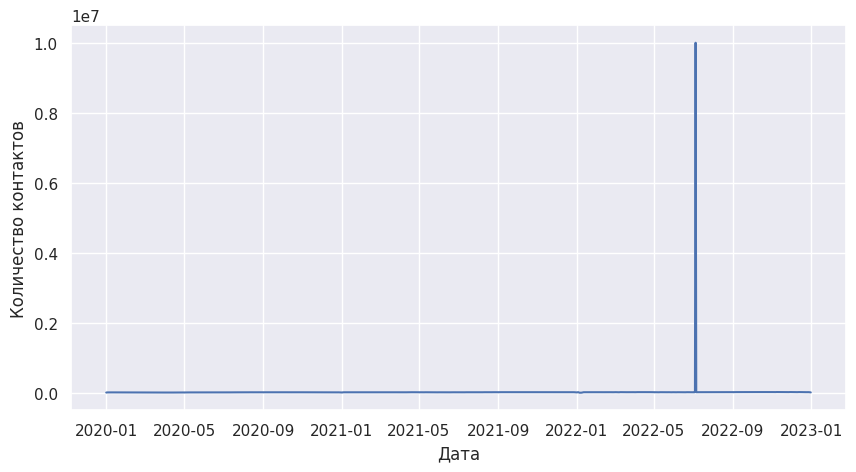

In [5]:
# Начнем с обычной визуализации всех наших данных
sns.set_theme(rc={'figure.figsize':(10,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=df.event_date, y=df.y);

In [6]:
# И базовых статистик количества контактов
df.describe()

,y
count,1096.0
mean,22644.69708
std,301666.45291
min,51.0
25%,11824.0
50%,13238.0
75%,15787.25
max,10000000.0


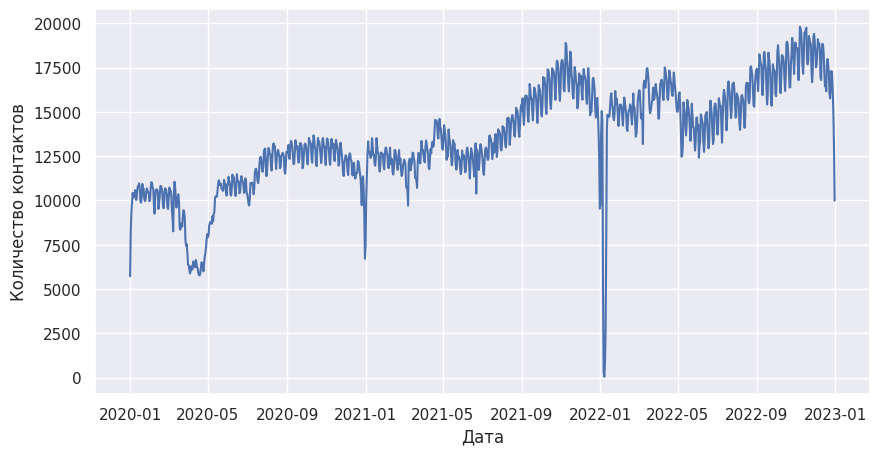

In [7]:
# Видим экстремально высокое значение (10000000), надо от него избавиться. Заменим его на среднее соседей и снова взглянем на данные
index = df['y'].argmax()
df['y'].iloc[index] = np.mean([df['y'].iloc[index-1], df['y'].iloc[index+1]])
sns.set_theme(rc={'figure.figsize':(10,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=df.event_date, y=df.y);

In [8]:
# Добавим отдельными признаками год, месяц, день и день недели, чтобы можно было использовать их в линейной регрессии
df['event_date'] = df['event_date'].apply(pd.to_datetime)
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day
df['week_day'] = df['event_date'].dt.weekday
df

,event_date,y,year,month,day,week_day
0,2020-01-01,5721,2020,1,1,2
1,2020-01-02,8274,2020,1,2,3
2,2020-01-03,9344,2020,1,3,4
3,2020-01-04,9864,2020,1,4,5
4,2020-01-05,10435,2020,1,5,6
...,...,...,...,...,...,...
1091,2022-12-27,17042,2022,12,27,1
1092,2022-12-28,16195,2022,12,28,2
1093,2022-12-29,14966,2022,12,29,3
1094,2022-12-30,13070,2022,12,30,4


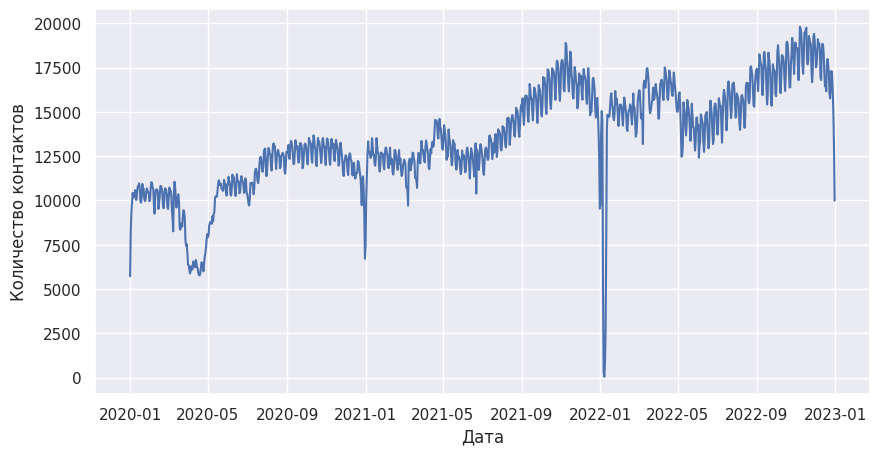

In [9]:
sns.set_theme(rc={'figure.figsize':(10,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=df.event_date, y=df.y);

In [10]:
# Добавим праздники как отдельный признак
holidays_kz = set(holidays.KZ(years=(2020, 2021, 2022, 2023)).keys())

df_holidays = pd.DataFrame.from_dict(holidays.KZ(years=(2020, 2021, 2022)), orient='index').rename(columns={0:'holiday'})
df_holidays['ds'] = df_holidays.index
    

df_holidays

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22
2020-03-21,Nauryz holiday,2020-03-21
2020-03-23,Nauryz holiday,2020-03-23
2020-05-01,Kazakhstan People Solidarity Holiday,2020-05-01
2020-05-07,Defender of the Fatherland Day,2020-05-07
2020-05-09,Victory Day,2020-05-09


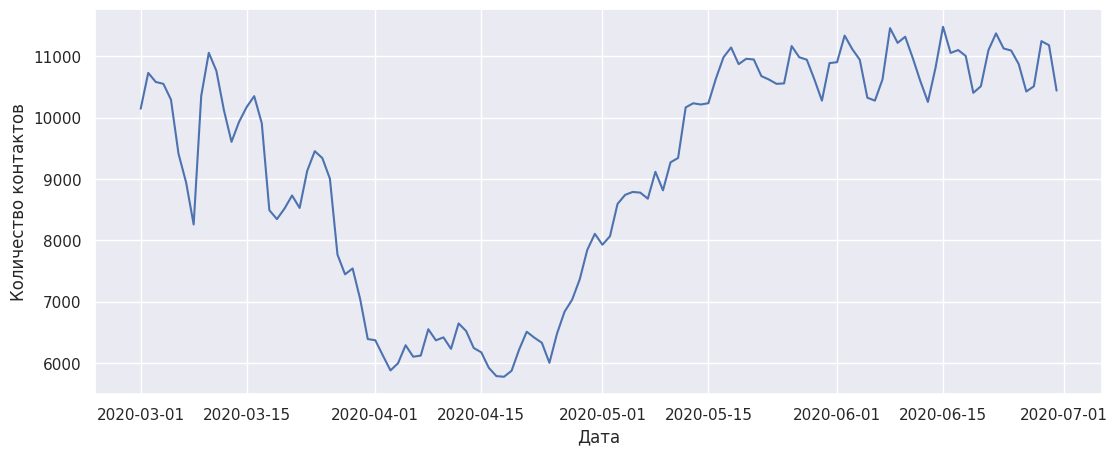

In [11]:
# И добавим ковид как отдельный признак
covid = df[(df.year == 2020) & ((df.month == 3)|(df.month == 4)|(df.month == 5)|(df.month == 6))]
sns.set_theme(rc={'figure.figsize':(13,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=covid.event_date, y=covid.y);

In [12]:
# Погуглила даты ЧП с ограничением выхода в Казахстане: с 15 марта по 11 мая, отметим эти данные
def is_covid(date):
    if pd.to_datetime(date) > pd.to_datetime('2020-03-15') and pd.to_datetime(date) < pd.to_datetime('2020-05-11'):
        return 1
    return 0

# Видим сильный провал в январе 2022 - Январские события. Причем просадка началась с 5 января и закончилась 10-м. 
# Для того, чтобы не сбивать модель заменим эти дни средним между 4 и 11 января

def is_kantar(date):
    if pd.to_datetime(date) > pd.to_datetime('2022-01-04') and pd.to_datetime(date) < pd.to_datetime('2022-01-12'):
        return 1
    return 0

def is_NewYear(date):
    if (date.month == 1 and date.day == 1) or (date.month == 12 and date.day == 31):
        return 1
    return 0


df['is_covid'] = df['event_date'].apply(is_covid)
df['is_NewYear'] = df['event_date'].apply(is_NewYear)
df['is_kantar'] = df['event_date'].apply(is_kantar)
df

,event_date,y,year,month,day,week_day,is_covid,is_NewYear,is_kantar
0,2020-01-01,5721,2020,1,1,2,0,1,0
1,2020-01-02,8274,2020,1,2,3,0,0,0
2,2020-01-03,9344,2020,1,3,4,0,0,0
3,2020-01-04,9864,2020,1,4,5,0,0,0
4,2020-01-05,10435,2020,1,5,6,0,0,0
...,...,...,...,...,...,...,...,...,...
1091,2022-12-27,17042,2022,12,27,1,0,0,0
1092,2022-12-28,16195,2022,12,28,2,0,0,0
1093,2022-12-29,14966,2022,12,29,3,0,0,0
1094,2022-12-30,13070,2022,12,30,4,0,0,0


In [13]:
# Подготавливаем данные для Prophet
df.rename(columns={"event_date": "ds"}, inplace=True)
df.index = pd.to_datetime(df['ds'])

In [14]:
initial = str(int(df.shape[0]/2)) + ' days'
horizon = str(int(df.shape[0]/10)) + ' days'
period = str(int(df.shape[0]/10)) + ' days'
print('initial', initial)
print('horizon', horizon)
print('period',  period)

initial 548 days
horizon 109 days
period 109 days


In [15]:
df

,ds,y,year,month,day,week_day,is_covid,is_NewYear,is_kantar
ds,,,,,,,,,
2020-01-01,2020-01-01,5721,2020,1,1,2,0,1,0
2020-01-02,2020-01-02,8274,2020,1,2,3,0,0,0
2020-01-03,2020-01-03,9344,2020,1,3,4,0,0,0
2020-01-04,2020-01-04,9864,2020,1,4,5,0,0,0
2020-01-05,2020-01-05,10435,2020,1,5,6,0,0,0
...,...,...,...,...,...,...,...,...,...
2022-12-27,2022-12-27,17042,2022,12,27,1,0,0,0
2022-12-28,2022-12-28,16195,2022,12,28,2,0,0,0
2022-12-29,2022-12-29,14966,2022,12,29,3,0,0,0


In [16]:
def get_mape(model,actual=df):
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat']) 


def plot(model,actual=df, threshold_changepoints=0.01):
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis=1)
    ax = df_plot[:].plot(y=["y", "yhat"],kind="line", figsize=(10, 10), xlabel='Дата', ylabel='Количество контактов')
    a = add_changepoints_to_plot(ax, model, df_pred,threshold = threshold_changepoints)

0.3392609702419722

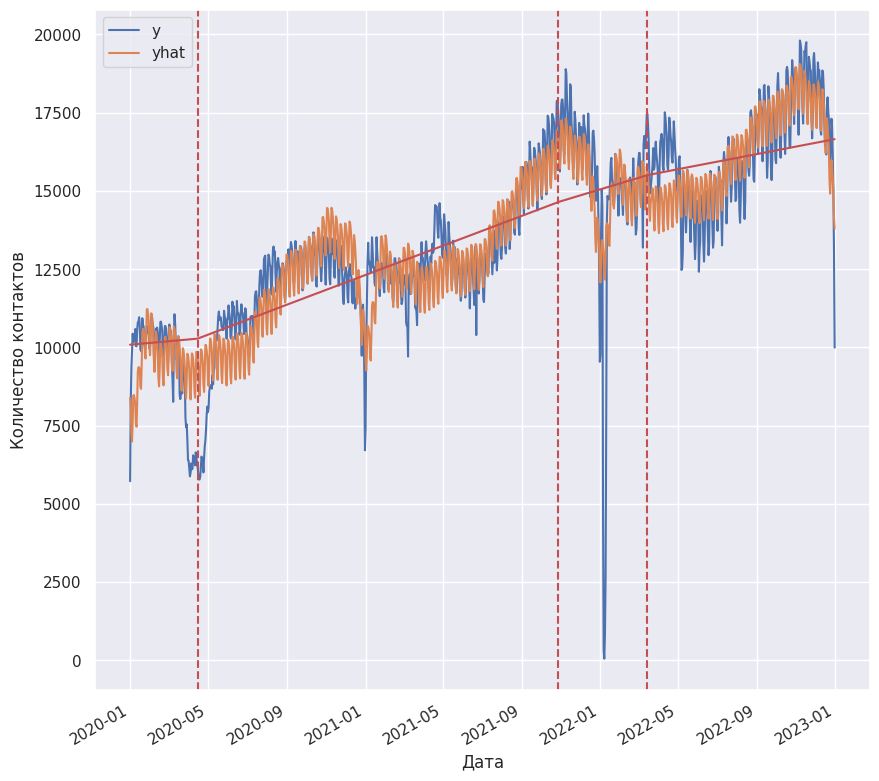

In [17]:
model = Prophet()
model.fit(df)
plot(model)
get_mape(model)

0.2805996424222753

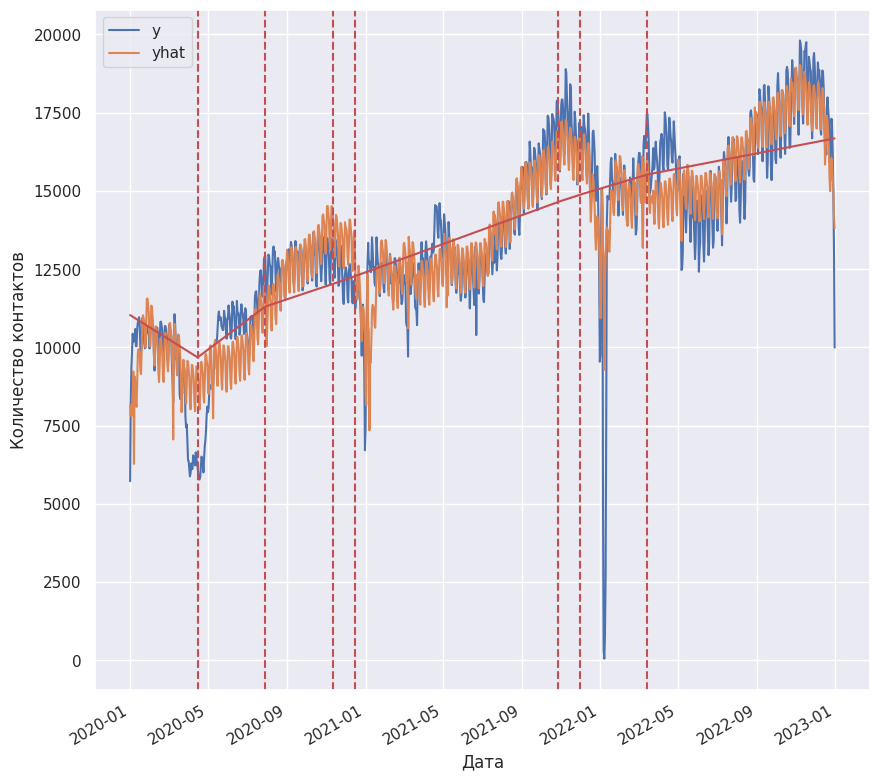

In [18]:
# праздники улучшают MAPE
model = Prophet(holidays=df_holidays)
with suppress_stdout_stderr():
    model.fit(df)
plot(model)
get_mape(model)

0.2688433931452222

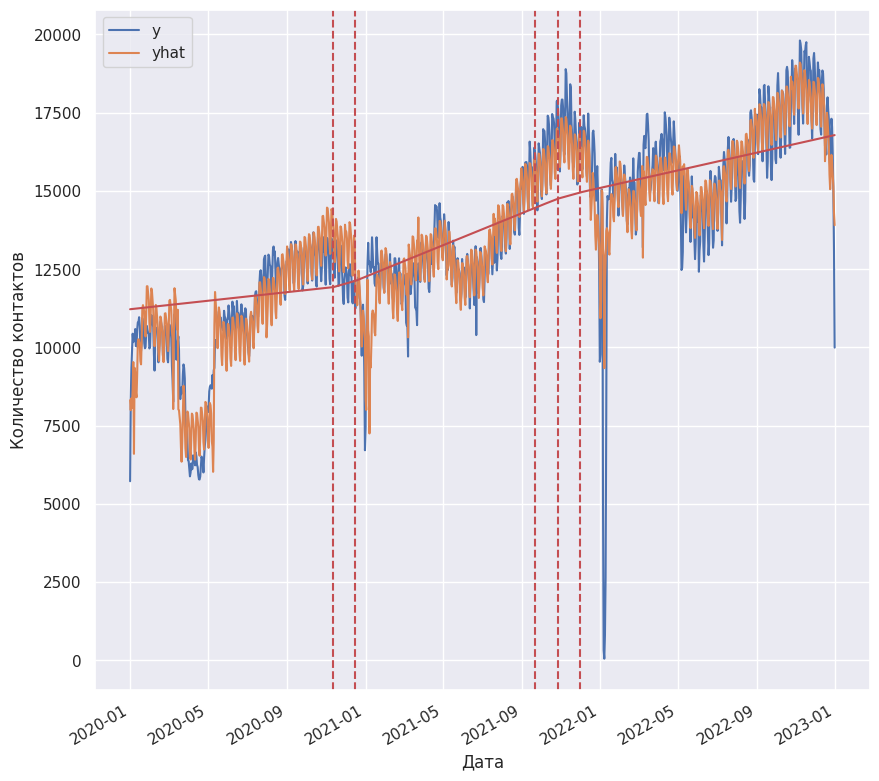

In [19]:
# добавили регрессор ковид, улучшили
model = Prophet(holidays = df_holidays).add_regressor('is_covid') 
with suppress_stdout_stderr():
    model.fit(df)
plot(model)
get_mape(model)

0.10796063193006428

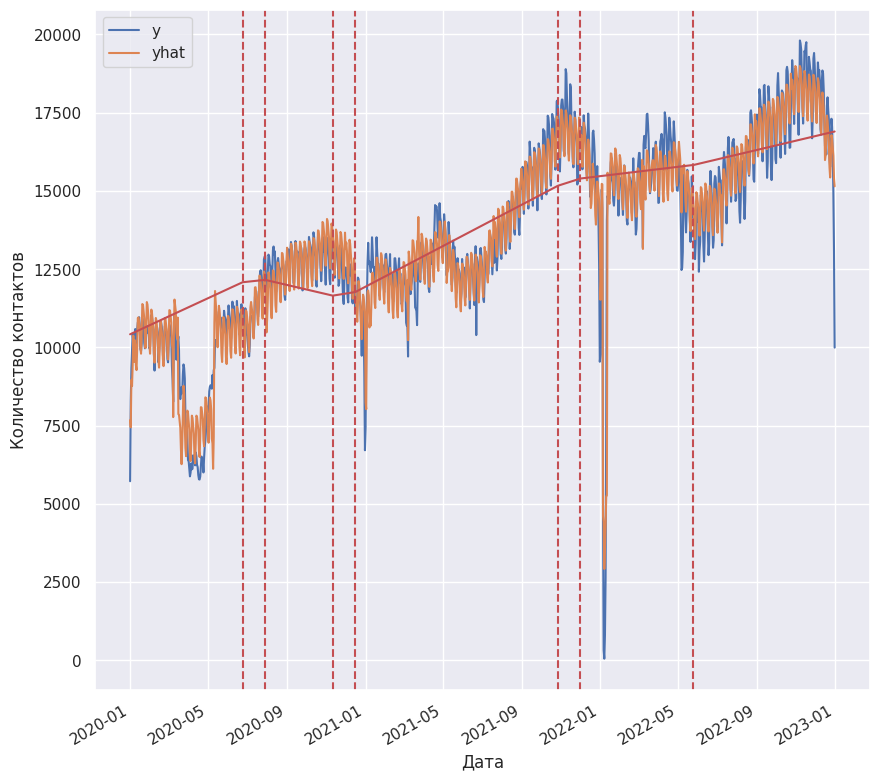

In [20]:
# Добавили регрессор с январскими событиями, тоже улучшили
model = Prophet(holidays=df_holidays).add_regressor('is_covid').add_regressor('is_kantar')
with suppress_stdout_stderr():
    model.fit(df)
plot(model)
get_mape(model)

0.10399893324759543

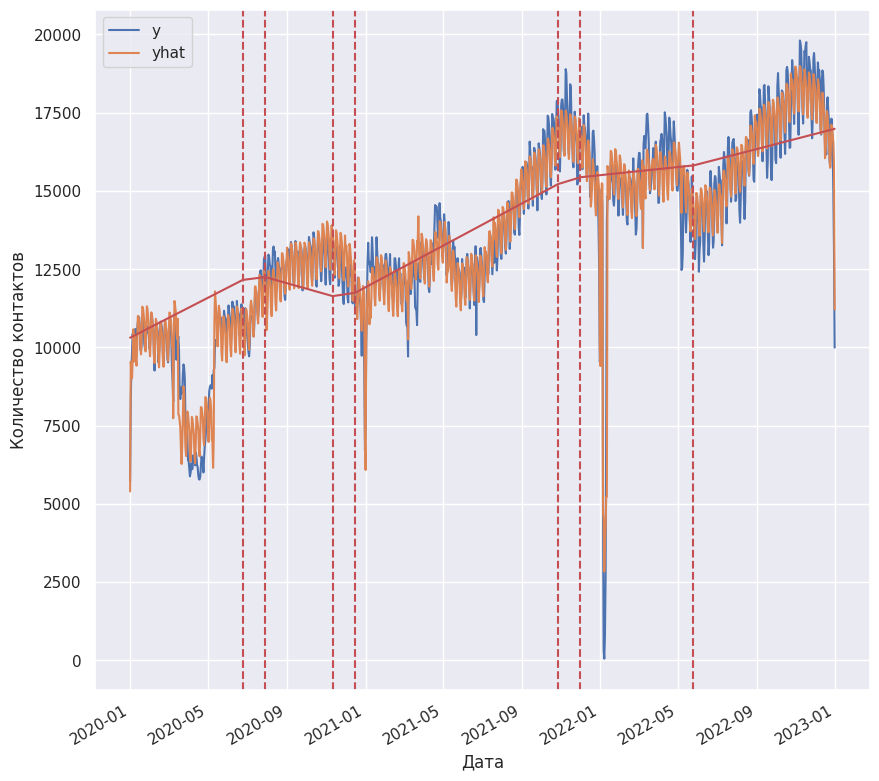

In [21]:
model = Prophet(holidays=df_holidays).add_regressor('is_covid').add_regressor('is_kantar').add_regressor('is_NewYear')
with suppress_stdout_stderr():
    model.fit(df)
plot(model)
get_mape(model)

In [22]:
# теперь потестим разные числовые параметры
def train(params):
    model = Prophet(holidays=df_holidays, **params
                   ).add_regressor('is_covid').add_regressor('is_kantar').add_regressor('is_NewYear')
    
    with suppress_stdout_stderr():
        model.fit(df)
        
    return get_mape(model)
   

In [23]:
param_grid = {
    'changepoint_prior_scale': np.logspace(0, 10, 3, base = 500**(1/10))/1000,
    'seasonality_prior_scale': np.logspace(0, 10, 3, base = 100**(1/10))/10,
    'holidays_prior_scale': np.logspace(0, 10, 3, base = 100**(1/10))/10,
    'seasonality_mode': ['multiplicative', 'additive']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [24]:
mapes = []

print(len(all_params))

start_time = time()   
with suppress_stdout_stderr():
    for params in all_params:
        mapes.append(train(params))

print('The time used is ', time()-start_time)
best_params = all_params[np.argmin(mapes)]
print(best_params)
'MAPE', min(mapes)

Optimization terminated abnormally. Falling back to Newton.


54


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

The time used is  122.12875652313232
{'changepoint_prior_scale': 0.49999999999999994, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.000000000000007, 'seasonality_mode': 'multiplicative'}


('MAPE', 0.08377161667117916)

0.08377161667117916

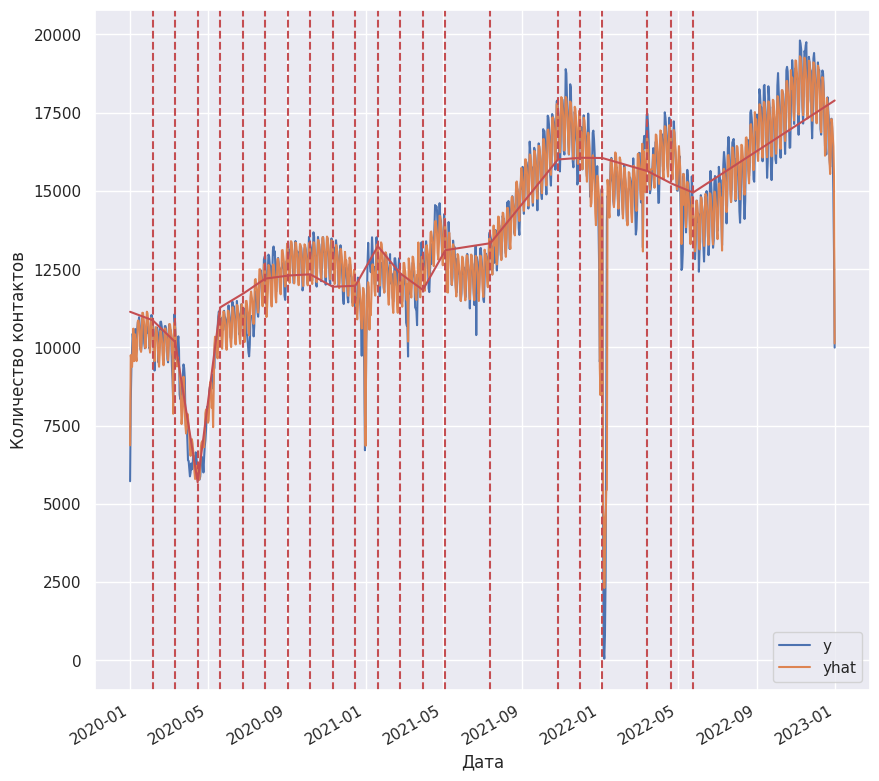

In [25]:
model = Prophet(holidays=df_holidays, **best_params).add_regressor('is_covid').add_regressor('is_kantar').add_regressor('is_NewYear')

with suppress_stdout_stderr():
    model.fit(df)
plot(model)
get_mape(model)

In [26]:
future = model.make_future_dataframe(periods=365)[-365:]
future['is_covid'] = future['ds'].apply(is_covid)
future['is_NewYear'] = future['ds'].apply(is_NewYear)
future['is_kantar'] = future['ds'].apply(is_kantar)
future

,ds,is_covid,is_NewYear,is_kantar
1094,2023-01-01,0,1,0
1095,2023-01-02,0,0,0
1096,2023-01-03,0,0,0
1097,2023-01-04,0,0,0
1098,2023-01-05,0,0,0
...,...,...,...,...
1454,2023-12-27,0,0,0
1455,2023-12-28,0,0,0
1456,2023-12-29,0,0,0
1457,2023-12-30,0,0,0


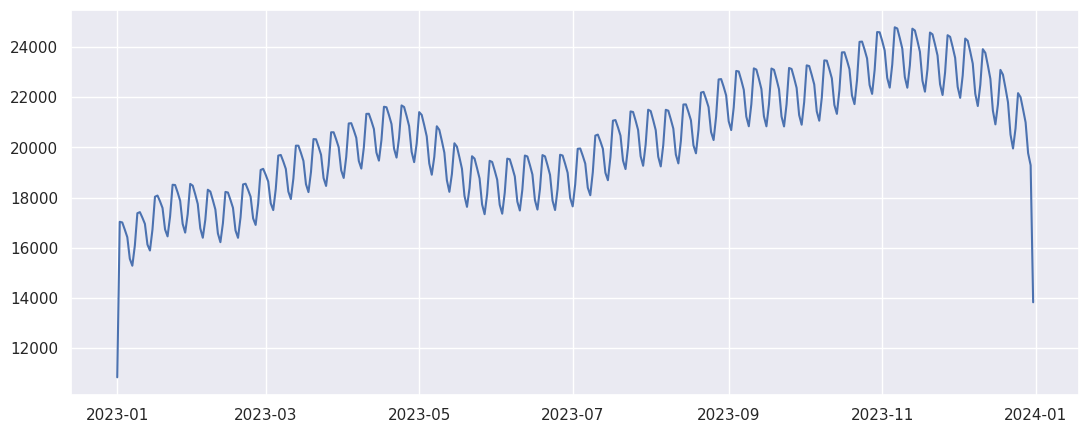

In [27]:
forecast = model.predict(future)
plt.plot(future['ds'], forecast['yhat']);

In [28]:
forecast['yhat'] = forecast['yhat'].apply(int)
res = forecast[['ds', 'yhat']]
res.to_csv('yhat.csv')
res

,ds,yhat
0,2023-01-01,10840
1,2023-01-02,17037
2,2023-01-03,17009
3,2023-01-04,16725
4,2023-01-05,16423
...,...,...
360,2023-12-27,21511
361,2023-12-28,20996
362,2023-12-29,19771
363,2023-12-30,19291
